In [201]:
# Libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [235]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50



In [263]:
dataset = tf.keras.preprocessing.image_dataset_from_directory( # allows us to load dataset that we have in our system
    'potato_dataset', #directory_name
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_SIZE, IMAGE_SIZE)
)

Found 2152 files belonging to 3 classes.


In [237]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [238]:
len(dataset)

68

we have 2152 files but it is just giving us 68, it is because we have divided 2165 files into 32 batches.

If we do 68 * 32 = 2516

In [239]:
68 * 32

2176

It is because we dont have complete 32 images in one batch

In [240]:
# let's take 1 batch and see

for image_batch, label_batch in dataset.take(2):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 2]
(32, 256, 256, 3)
[0 2 1 1 0 1 0 1 2 0 0 0 0 2 0 1 0 0 1 0 1 1 2 1 2 1 0 0 1 1 0 1]


2024-06-24 13:22:18.036347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


image_batch: 32 is batch size, 256, 256 is image size and 3 is rgb_channel

label_batch: three classes (0,1,2) which are  'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy' respectively


2024-06-24 13:22:18.745348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


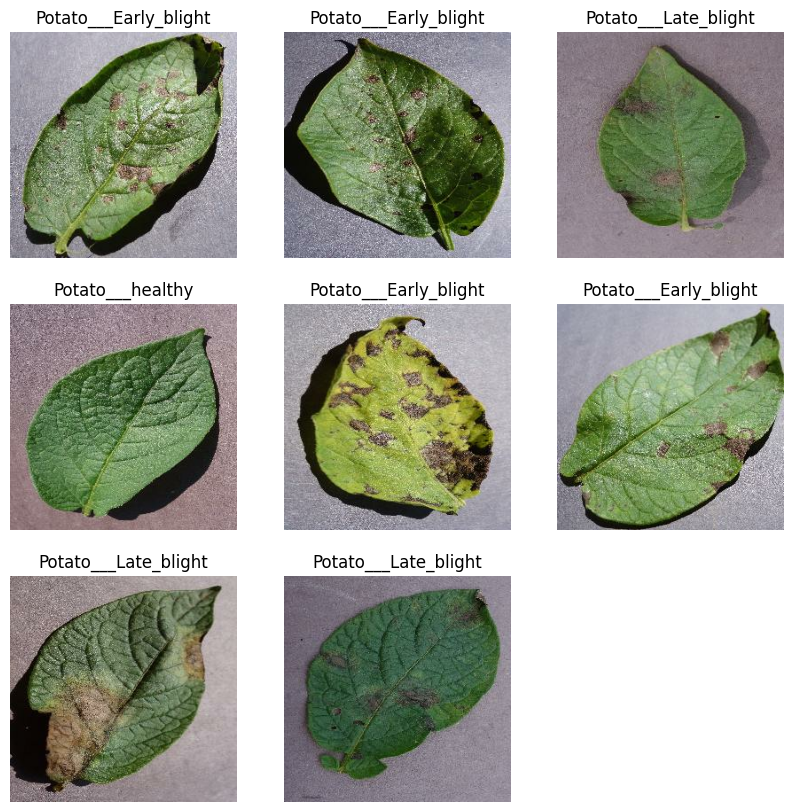

In [241]:
# Let's visualize  Image randomly.
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(2):
    # let's visualize multiples images 
    for i in range(8):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off') # hides x and y axis

Every_time you run this cell, you see different image because it is shuffled

### Now we can divide training and testing size to 80% and 20% respectively.

In [242]:
# 80% is 0.8 so,

train_size = 0.8

len(dataset) * train_size

54.400000000000006

In [243]:
# Let's take 54 as our training sample

train_ds = dataset.take(54)
len(train_ds)

54

In [244]:
# After taken the training sample, we know rest are testing samples

testing_ds = dataset.skip(54)
len(testing_ds)

14

In [245]:
val_size = 0.1

len(dataset) * val_size

6.800000000000001

In [246]:
val_ds = testing_ds.take(6)
len(val_ds)

6

In [247]:
testing_ds = testing_ds.skip(6)
len(testing_ds)

8

In [248]:
def dataset_partiation(ds, train_split=0.8, test_split = 0.1, val_split = 0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12) # seed can be any number, if you do same seed everytime it gives you same result

    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

    return 

In [249]:
train_ds, val_ds, test_ds = dataset_partiation(dataset)

In [250]:
len(train_ds)

54

In [251]:
len(test_ds)

8

In [252]:
len(val_ds)

6

### Input PipeLine Optimization

In [253]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


Cache:  opens and read the image from the disk and does'nt have to open it again for next iteration or epoch. It optimizes input pipeline.

prefetching: If Gpu is busy, prefetch will load next set of batch from the disk and that will imporve the performancs.

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [254]:
resizeAndRescaling= tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE), # incase we don't have image size of 256
    layers.Rescaling(1.0/255) # by dividing by 255, we will have value in range of 0 to 1, which improves model performance.

])
resizeAndRescaling

<Sequential name=sequential_73, built=False>

## Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [255]:
dataAugmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    # layers.RandomRotation(0.2),
])

dataAugmentation


<Sequential name=sequential_74, built=False>

### Applying Data Augmentation to Train Dataset


In [256]:
train_ds = train_ds.map(lambda x,y: (dataAugmentation(x, training=True), y)
                        ).prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

### We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [257]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resizeAndRescaling,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/home/jagannath/end_to_end_dl_projects/dl_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [258]:
model.summary()

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_73 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_328 (Conv2D)             │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_326               │ (32, 127, 127, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_329 (Conv2D)             │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_327               │ (32, 62, 62, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_330 (Conv2D)             │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_328               │ (32, 30, 30, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_331 (Conv2D)             │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_329               │ (32, 14, 14, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_332 (Conv2D)             │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_330               │ (32, 6, 6, 64)         │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_333 (Conv2D)             │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_331               │ (32, 2, 2, 64)         │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_54 (Flatten)            │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [259]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [260]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5


2024-06-24 13:23:04.979348: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.
2024-06-24 13:23:07.350867: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.


 1/54 ━━━━━━━━━━━━━━━━━━━━ 6:48 8s/step - accuracy: 0.1562 - loss: 1.1089

2024-06-24 13:23:08.077485: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.
2024-06-24 13:23:09.254778: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.


 2/54 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.2188 - loss: 1.1027

2024-06-24 13:23:10.053085: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.


54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.4220 - loss: 0.9470 - val_accuracy: 0.7292 - val_loss: 0.8581
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6360 - loss: 0.7987 - val_accuracy: 0.6667 - val_loss: 0.9201
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7184 - loss: 0.6893 - val_accuracy: 0.7448 - val_loss: 0.6605
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8221 - loss: 0.4582 - val_accuracy: 0.8594 - val_loss: 0.2955
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8979 - loss: 0.2647 - val_accuracy: 0.9323 - val_loss: 0.1781


### Epochs
Epoch refers to the one entire passing of training data through the algorithm.

The more number of epoch you have, the more your model recognize.

In [264]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 435ms/step - accuracy: 0.9183 - loss: 0.1654


[0.17569348216056824, 0.91796875]

You can see above that we get 91% accuracy for our test dataset. This is considered to be a pretty good accuracy



In [265]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

Those are what i used for building model. 

In [266]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [273]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']





### Let's see how training is different from validation accuracy


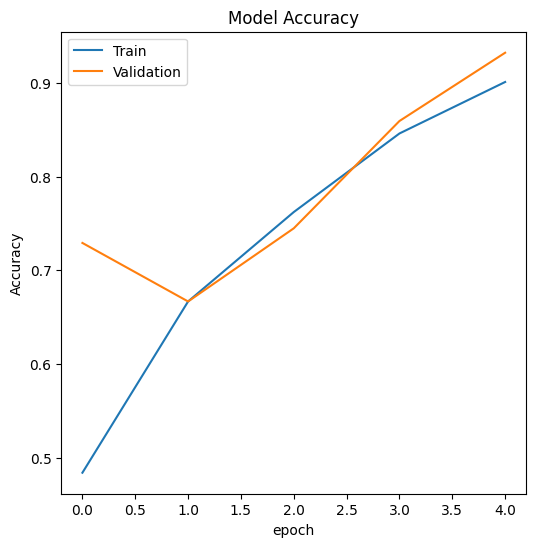

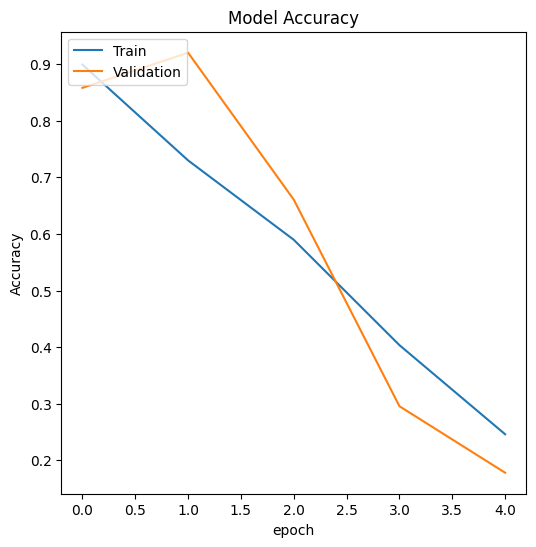

In [283]:
plt.figure(figsize=(6,6))
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.figure(figsize=(6,6))
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

2024-06-24 14:31:57.070927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


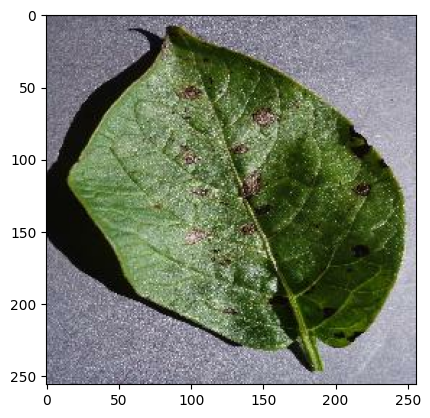

In [295]:
for image_batchs, label_batchs in test_ds.take(2):
    plt.imshow(image_batch[1].numpy().astype('uint8'))

first image to predict: 
Actual Label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
Predicted label: Potato___Early_blight


2024-06-24 14:49:39.237611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


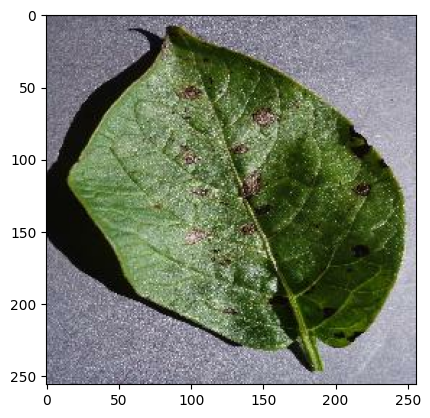

In [314]:

import numpy as np
for image_batchs, label_batchs in test_ds.take(1):
    fist_img = (image_batch[1].numpy().astype('uint8'))
    first_label = label_batch[1].numpy()

    print("first image to predict: ")
    plt.imshow(fist_img)
    print(f'Actual Label: {class_names[first_label]}')


    # predict which image it is
    batch_predict = model.predict(image_batchs)
    print(f'Predicted label: {class_names[np.argmax(batch_predict[0])]}')



In [322]:
# Write a function for inference

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)


    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


2024-06-24 15:15:55.732967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


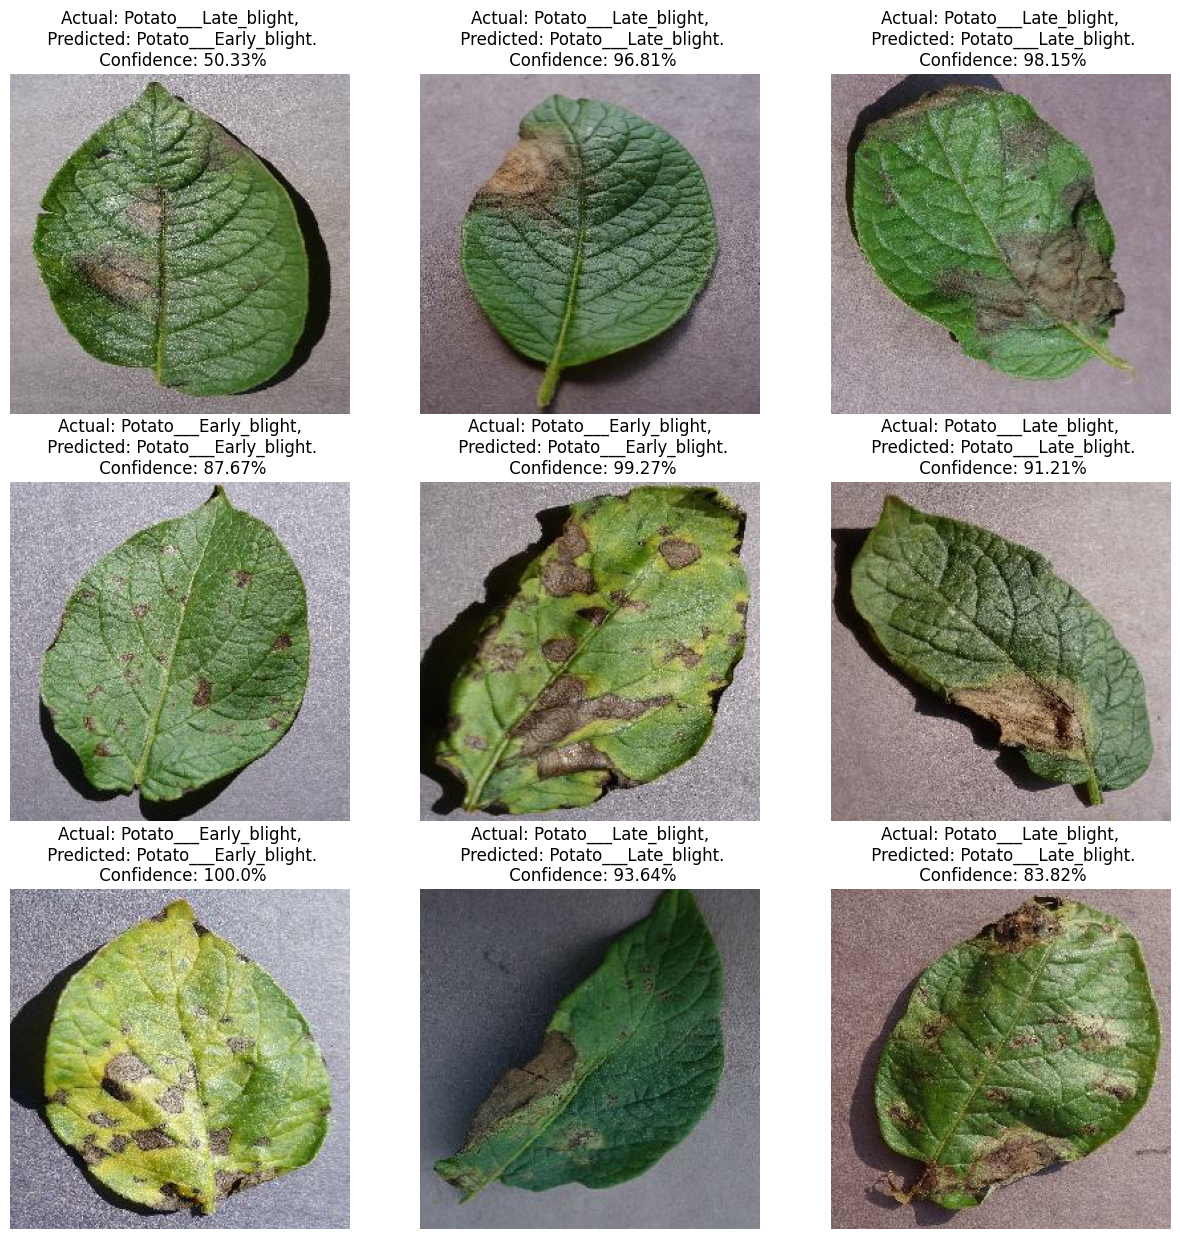

In [336]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [345]:
import os


In [344]:
dir = 'models'
if not os.path.exists(dir):
    os.makedirs(dir)

model_path = os.path.join(dir, 'my_model.h5')
model.save(model_path)